<a href="https://colab.research.google.com/github/p20230445-bits/crux-inductions-2025/blob/main/notebooks/Task1_KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [37]:
# Spline Function (piecewise linear)
class Spline:
    def __init__(self, num_knots=5):
        self.num_knots = num_knots
        self.knots = np.linspace(0, 1, num_knots)
        self.coeffs = np.random.randn(num_knots) * 0.1  # learnable params

    def forward(self, x):
        # Piecewise linear interpolation
        return np.interp(x, self.knots, self.coeffs)

    def plot(self):
        xs = np.linspace(0, 1, 100)
        ys = [self.forward(x) for x in xs]
        plt.plot(xs, ys, label="Learned Spline")
        plt.scatter(self.knots, self.coeffs, color="red")
        plt.legend()
        plt.show()

In [38]:
# Simple KAN Layer
class KANLayer:
    def __init__(self, input_dim, output_dim, num_knots=5):
        self.splines = [[Spline(num_knots) for _ in range(input_dim)]
                        for _ in range(output_dim)]
        self.bias = np.zeros((1, output_dim))

    def forward(self, X):
        out = []
        for j in range(len(self.splines)):  # for each output neuron
            val = sum(self.splines[j][i].forward(X[:, i])
                      for i in range(len(self.splines[j])))
            out.append(val + self.bias[0, j])
        return np.vstack(out).T  # shape (batch, output_dim)

In [39]:
# KAN Model
class SimpleKAN:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.01):
        self.hidden = KANLayer(input_dim, hidden_dim)
        self.out_W = np.random.randn(hidden_dim, output_dim) * 0.1
        self.out_b = np.zeros((1, output_dim))
        self.lr = lr

    def forward(self, X):
        self.z1 = self.hidden.forward(X)
        self.a1 = np.maximum(0, self.z1)  # ReLU
        logits = np.dot(self.a1, self.out_W) + self.out_b
        exp_scores = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        self.a2 = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.a2

    def compute_loss(self, y_onehot):
        m = y_onehot.shape[0]
        log_likelihood = -np.log(self.a2[range(m), np.argmax(y_onehot, axis=1)])
        return np.sum(log_likelihood) / m

    def train(self, X, y, epochs=100):
        # One-hot encode y
        enc = OneHotEncoder(sparse_output=False)
        y_onehot = enc.fit_transform(y.reshape(-1, 1))
        for epoch in range(epochs):
            probs = self.forward(X)
            loss = self.compute_loss(y_onehot)

            # Gradients for output layer
            dz2 = probs - y_onehot
            dW = np.dot(self.a1.T, dz2) / X.shape[0]
            db = np.sum(dz2, axis=0, keepdims=True) / X.shape[0]

            # Update output layer weights
            self.out_W -= self.lr * dW
            self.out_b -= self.lr * db

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


In [40]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target
X = (X - X.min()) / (X.max() - X.min())  # normalize to [0,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Train KAN
kan = SimpleKAN(input_dim=4, hidden_dim=10, output_dim=3, lr=0.1)
kan.train(X_train, y_train, epochs=100)

Epoch 0, Loss: 1.1007
Epoch 10, Loss: 1.0920
Epoch 20, Loss: 1.0838
Epoch 30, Loss: 1.0759
Epoch 40, Loss: 1.0682
Epoch 50, Loss: 1.0607
Epoch 60, Loss: 1.0533
Epoch 70, Loss: 1.0460
Epoch 80, Loss: 1.0388
Epoch 90, Loss: 1.0317


In [42]:
# Evaluate
preds = kan.predict(X_test)
acc = np.mean(preds == y_test)
print(f"Test Accuracy: {acc:.2f}")

Test Accuracy: 0.63


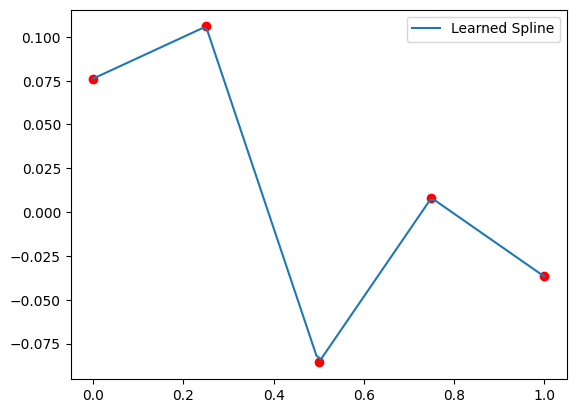

In [43]:
# Plot spline of first hidden neuron, first input
kan.hidden.splines[0][0].plot()

In [46]:
!git clone https://github.com/p20230445-bits/crux-inductions-2025.git
%cd crux-inductions-2025

Cloning into 'crux-inductions-2025'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 47 (delta 9), reused 40 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 8.43 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/crux-inductions-2025
